# Darts

In [1]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset # type: ignore

In [2]:
AirPassengersDataset().load().pd_series()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Name: #Passengers, Length: 144, dtype: float64

In [4]:
MonthlyMilkDataset().load().pd_series()

Month
1962-01-01    589.0
1962-02-01    561.0
1962-03-01    640.0
1962-04-01    656.0
1962-05-01    727.0
              ...  
1975-08-01    858.0
1975-09-01    817.0
1975-10-01    827.0
1975-11-01    797.0
1975-12-01    843.0
Freq: MS, Name: Pounds per cow, Length: 168, dtype: float64

## build a model to both the datasets

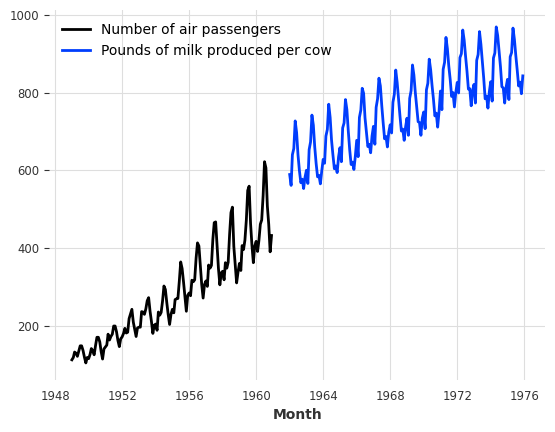

In [3]:
import matplotlib.pyplot as plt

series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label='Number of air passengers')
series_milk.plot(label='Pounds of milk produced per cow')
plt.legend()

## bring both the datasets into a scale

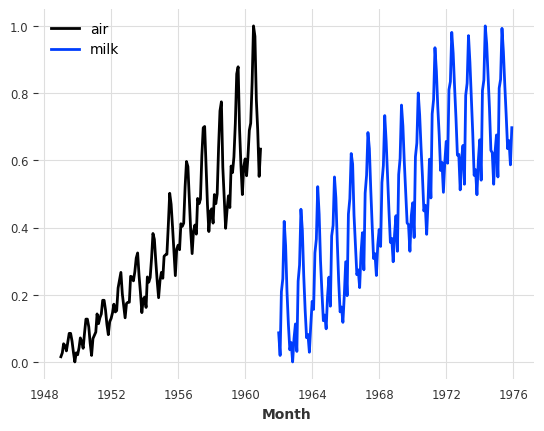

In [5]:
from darts.dataprocessing.transformers import Scaler # type: ignore

scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label='air')
series_milk_scaled.plot(label='milk')

plt.legend()

# as we can see it in the plot, the both datasets are in the same scale
# both starts from 0.0

## split for train & validation

In [6]:
# train & validation split
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

## build model

[Darts documentation](https://pypi.org/project/darts/)

In [8]:
from darts import TimeSeries                                                                            # type: ignore
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries   # type: ignore
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel               # type: ignore
from darts.metrics import mape, smape                                                                   # type: ignore

### NBEATSModel

[NBEATSModel paper](../../docs/doc/NBEATSModel/1905.10437v4.pdf)

<p>N-BEATS model focus on solving the univariate times series point forecasting problem using deep learning. We propose a deep neural architecture based on backward and forward residual links and a very deep stack of fully-connected layers. 
The architecture has a number of desirable properties, being interpretable, applicable without modification to a wide array of target domains, and fast to train. 
We test the proposed architecture on several well-known datasets, including M3, M4 and TOURISM competition datasets containing time series from diverse domains. 
We demonstrate state-of-the-art performance for two configurations of N-BEATS for all the datasets, improving forecast accuracy by 11% over a statistical benchmark and by 3% over last year's winner of the M4 competition, a domain-adjusted hand-crafted hybrid between neural network and statistical time series models. The first configuration of our model does not employ any time-series-specific components and its performance on heterogeneous datasets strongly suggests that, contrarily to received wisdom, deep learning primitives such as residual blocks are by themselves sufficient to solve a wide range of forecasting problems. Finally, we demonstrate how the proposed architecture can be augmented to provide outputs that are interpretable without considerable loss in accuracy.</p>

In [9]:
model_air_milk = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0)

In [10]:
model_air_milk.fit([train_air, train_milk], verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 6GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
--------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 7.16%


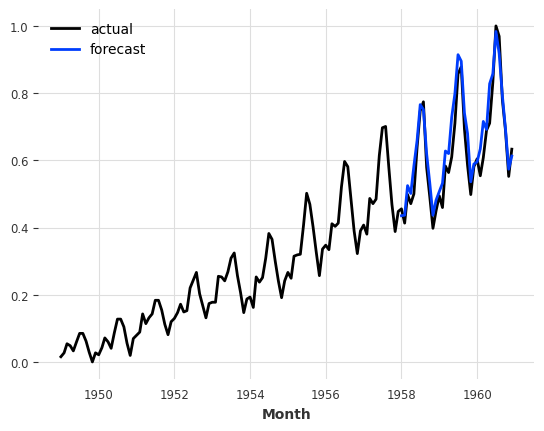

In [11]:
pred = model_air_milk.predict(n=36, series=train_air)

series_air_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend()

print('MAPE = {:.2f}%'.format(mape(series_air_scaled, pred)))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 13.34%


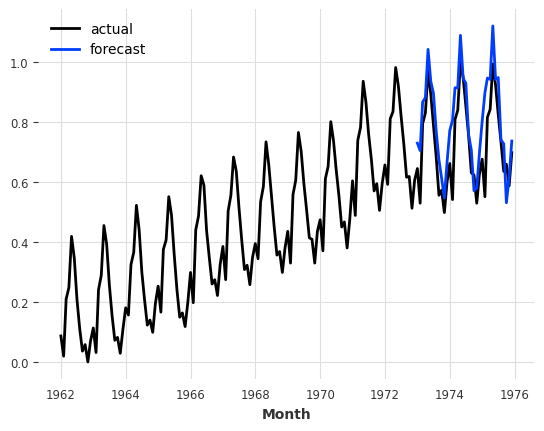

In [12]:
pred = model_air_milk.predict(n=36, series=train_milk)

series_milk_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend()

print('MAPE = {:.2f}%'.format(mape(series_milk_scaled, pred)))